In [1]:
import os
import pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.preprocessing import LabelEncoder
from functions import *
from functions_plots import *

In [2]:
# Load data
data_folder_path = Path('../../data/')
data = pd.read_csv(data_folder_path / 'data_train_all.csv')
data_columns = pd.read_csv(data_folder_path / 'data_train_all_columns.csv')

print("Training data length:", len(data))

predictor_columns = data_columns[data_columns['column_type'].isin(['predictor_n_grams', 'predictor_continuous'])]['column_name'].tolist()
print(f"Number of predictor columns: {len(predictor_columns)}")

target_columns = data_columns[data_columns['column_type'] == 'target']['column_name'].tolist()
print(f"Target columns: {target_columns}")

# Merge back with the raw data so that we can use the extra column to filter later
data_raw = pd.read_csv(data_folder_path / 'chordonomicon_raw.csv', low_memory=False)

# print(data_raw.columns)
# print(data.columns)

keys = ['spotify_song_id', 'decade', 'main_genre']
data = data.merge(data_raw, on=keys, how='left', suffixes=('', '_raw'))

Training data length: 255606
Number of predictor columns: 119
Target columns: ['spotify_popularity', 'on_hot100', 'decade', 'main_genre']


In [3]:
# Select target variable and type

target_variable = 'decade'
target_type = 'multiclass'

# target_variable = 'main_genre'
# target_type = 'multiclass'

# target_variable = 'spotify_popularity'
# target_type = 'regression'

# target_variable = 'on_hot100'
# target_type = 'binary'

# Drop NaN values in target variable from entire dataset
if data[target_variable].isna().any():
    data = data[data[target_variable].notna()].reset_index(drop=True)
    print(f"Rows after dropping NaN in {target_variable}: {len(data)}")

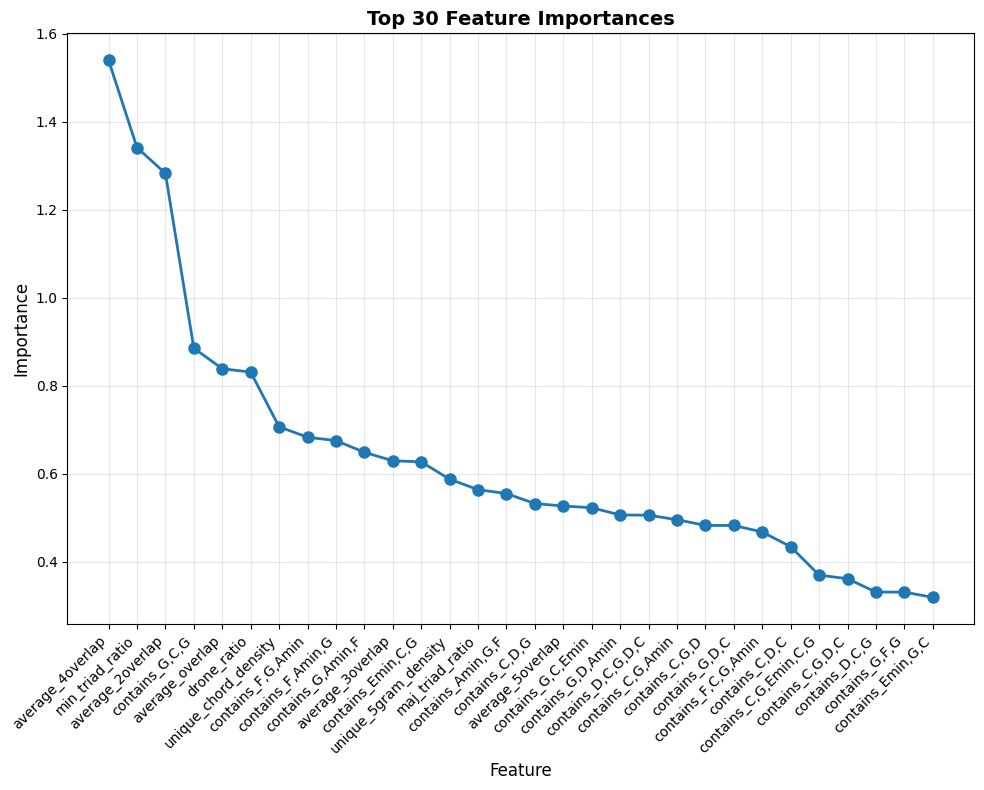

In [4]:
# select features here
path_feature_selection = Path('../feature_selection/feature_selection')
# print(os.listdir(path_feature_selection))

feature_selection = pd.read_csv(path_feature_selection / f'lasso_feature_importance_{target_variable}.csv')
# print(feature_selection.columns)

# # Plot feature importance for all features
# ax = plot_feature_importance(feature_selection)

# Plot feature importance for top N features
ax = plot_feature_importance_df(feature_selection, top_n=30)

# Select top N features or comment out to use all features
predictor_columns = feature_selection.head(20)['feature'].astype(str).tolist()

In [5]:
# Filter data here

data_filtered = data[pd.to_numeric(data['decade'], errors='coerce') >= 1990].reset_index(drop=True)

unique_decades = pd.to_numeric(data_filtered['decade'], errors='coerce').dropna().astype(int).unique()
unique_decades = sorted(unique_decades)
print("Unique decades after filter:", unique_decades)

# Make a dataframe with predictor features
data_X = data_filtered[predictor_columns]

Unique decades after filter: [np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]


In [6]:
# 5-fold cross validation (stratified for classification to keep class ratios per fold)
if target_variable == 'spotify_popularity':
    # Use regular KFold for regression
    cv = KFold(n_splits=5, shuffle=True, random_state=145)
else:
    # Use StratifiedKFold for classification tasks
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=145)

# When modeling genre, we need to encode the labels (all other target variables are numeric already)
if target_variable == 'main_genre':
    le = LabelEncoder()
    data_y = le.fit_transform(data_filtered[target_variable])
else:
    data_y = data_filtered[target_variable]

In [7]:
results_dummy = evaluate_dummy_baseline(data_X, data_y, cv=cv, target_type=target_type, random_state=0)


Evaluating Dummy Baseline...
Cross-validation folds: 5

Dummy Baseline - Multiclass Target
Parameters: strategy=most_frequent

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.4912 (+/- 0.0000)
Precision Micro               :  0.4912 (+/- 0.0000)




In [8]:
# Train and fit logistic regression model here (uses ridge regression for regression variables)
results_lr = train_logistic_regression(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    random_state=42
)


Training Logistic Regression/Ridge...
Cross-validation folds: 5

Logistic Regression - Multiclass Target
Parameters: C=1.0, penalty=l2, solver=lbfgs

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.4960 (+/- 0.0011)
F1 Micro                      :  0.4960 (+/- 0.0011)
Precision Micro               :  0.4960 (+/- 0.0011)
Recall Micro                  :  0.4960 (+/- 0.0011)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.4961 (+/- 0.0003)
F1 Micro                      :  0.4961 (+/- 0.0003)
Precision Micro               :  0.4961 (+/- 0.0003)
Recall Micro                  :  0.4961 (+/- 0.0003)




In [9]:
# Train and fit Lasso model here
results_lasso = train_lasso(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    alpha=0.1,
    max_iter=5000,
    random_state=42
)



📐 Training Lasso...
Cross-validation folds: 5

Lasso - Multiclass Target
Parameters: alpha=0.1, max_iter=5000

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.4959 (+/- 0.0011)
F1 Micro                      :  0.4959 (+/- 0.0011)
Precision Micro               :  0.4959 (+/- 0.0011)
Recall Micro                  :  0.4959 (+/- 0.0011)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.4961 (+/- 0.0003)
F1 Micro                      :  0.4961 (+/- 0.0003)
Precision Micro               :  0.4961 (+/- 0.0003)
Recall Micro                  :  0.4961 (+/- 0.0003)




In [10]:
# Train and fit Random Forests model here
results_rf = train_random_forest(
    data_X,
    data_y,
    cv=cv,
    target_type=target_type,
    n_estimators=100,
    max_depth=None,
    random_state=42
)


Training Random Forest...
Cross-validation folds: 5

Random Forest - Multiclass Target
Parameters: n_estimators=100, max_depth=None, min_samples_leaf=1

Test Performance (Out-of-Sample):
------------------------------------------------------------
Accuracy                      :  0.4833 (+/- 0.0021)
F1 Micro                      :  0.4833 (+/- 0.0021)
Precision Micro               :  0.4833 (+/- 0.0021)
Recall Micro                  :  0.4833 (+/- 0.0021)

Train Performance (In-Sample):
------------------------------------------------------------
Accuracy                      :  0.9867 (+/- 0.0001)
F1 Micro                      :  0.9867 (+/- 0.0001)
Precision Micro               :  0.9867 (+/- 0.0001)
Recall Micro                  :  0.9867 (+/- 0.0001)


